## Create lists for days and behaviours and a tuple for every (day, behaviour) combination

In [108]:
#create pairs of days and behaviours
list_day_no = range(1, 9) + range(11, 31)
list_behaviours = ['SW', 'FO','AR', 'BLM', 'BNV', 'BR', 'DF', 'DF-TFW', 'DR', 'DS', 'DS-TFW', 'DU', 'GF', 'GF-TFW', 'IN', 'LM', 'LM-CF', 'LY', 'NV', 'OC', 'PDS', 'RE', 'SU', 'TR']
day_behaviours_list = [(x,y) for x in list_day_no for y in list_behaviours]


#use for testing 
#test_day_no = range(1, 4)
#test_behaviours = ['SW', 'FO']
test = [(x,y) for x in test_day_no for y in list_behaviours]


# Functions

In [109]:
def yes_no_every_second(start, finish): #creates an  entry for every second of the day between 5am (18000) and 8pm (72000), 1 for a yes and 0 for a no 
    i = 18000  # ie starts at 5am
    yes_list = []
    if len(start) == 0: #deals with behaviours that do not occur on a given day
        yes_list = ['0']*54000
    while i < 72000: # ends the time span at 8pm 
        for s in range(0, len(start)): # len(start) is the number of instances of the behaviour recorded that day
            if  i == int(start[s]): # this deals with the start and finish time of a behaviour instance
                yes_list.append(1)
            elif  i == int(finish[s]): # this deals with the start and finish time of a behaviour instance
                yes_list.append(0)
            elif i > int(start[s]) and i < int(finish[s]): #deals with seconds in between a start and finish time
                yes_list.append(1)
            elif s-1 >= 0 and i > int(finish[s-1]) and i < int(start[s]):#for all but the first st, any second in between st and previous ft is a no
                yes_list.append(0)
            elif s == (len(start) -1) and i > int(finish[s]):#anything greater than last ft is a no
                yes_list.append(0)
            elif s == 0 and i < int(start[s]):# #anyhing before first st is a no
                yes_list.append(0)
        i = i + 1
    print len(yes_list)
    return yes_list

In [110]:
def tsb(day_behaviour):# transforms the date to %tsb in 15 minute intervals
    day, behaviour = day_behaviour #unpack the tuple
    print day, behaviour# enables uses to keep track of where the programme is
    current = zoo[(zoo.DayNo == day) & (zoo.Behaviour == behaviour)] #subset the data frame for specific day and behaviour
    start = current['start_time'].tolist() #create lists for start and finish times
    finish = current['finish_time'].tolist()
    yes_no = pd.DataFrame(yes_no_every_second(start, finish), columns = ['yes_no'])#convert into yes no for every second of the day from 5am to 8pm
    yes_no['time in sec'] = pd.timedelta_range(start='05:00:00', end='19:59:59', freq='1S')# creates required time interval data
    yes_no = yes_no.set_index('time in sec')#sets time as the index
    TSB = pd.DataFrame((yes_no['yes_no']).resample('15min').sum().apply(lambda x: (float(x)/900)*100)) #Downsample into 15 min intervals and convert to % TSB
    TSB = TSB.rename(columns = {'yes_no':'TSB (%)'})
    TSB['DayNo'] = day #add day and behaviour to the data frame
    TSB['Behaviour'] = behaviour
    return TSB   
    
    

### Functions for Data Quality checks

In [111]:
def missing_values(df):
    print 'Summary of missing values'
    print zoo.isnull().sum()
    print '###############################'


In [112]:
#checks that every start time is less than the corresponding finish time
#use after times have been converted to seconds
def start_greater_than_finish(df):
    start_greater_than_finish = df.query('start_time > finish_time')
    if len(start_greater_than_finish) == 0:
        print 'Start times are less than corresponding finish times?'
        print 'Pass: All start times less than corresponding finish times'
        print '###############################'
    else:
        print 'Start times are less than corresponding finish times?'
        print 'Fail: some start times greater than corresponding finish times'
        print start_greater_than_finish
        print '###############################'
    
    

In [113]:
#checks that every start time is equal to the previous finish time for a single day
#called within secons function that loops through the days
def start_equals_previous_finish_day(df, day):
       
    current = df[(df.DayNo == day)]
    diff = current.start_time - current.finish_time.shift()
    diff = diff.iloc[1:] #remove first entry as there is no previous finish time for it
    if diff.sum() == 0:
        print 'Day No', day,': Pass'
       
    else:
        print 'Day No', day, 'Fail: The start time does not equal the previous finish time for the following rows'
        print diff[(diff != 0)]        


In [114]:
#loops through all days checking start time is equal to previous finish time
#use after time has been converted to seconds

def start_equals_previous_finish_all(df, list_of_days):
    print 'Every start time equals previous finish time?'
    [start_equals_previous_finish_day(df, day) for day in list_of_days]
    print '###############################'

In [115]:
#check start time is 5am
#use after times converted to seconds
def check_start_5am(df):
    check_start = df.groupby(['DayNo'])['start_time'].min() == 18000
    check_finish = df.groupby(['DayNo'])['finish_time'].max() == 72000
    values = check_start.unique()
    if len(values) == 1 and values[0] == True:
        print 'Start at 5am?'
        print 'Pass: All days start at 5am'
        print '###############################'
    else:
        print 'Start at 5am?'
        print 'Not all days start at 5am'
        print check_start[check_start == False]
        print '###############################'


In [116]:
#check finish time is 8pm
#use after time has been converted to seconds
def check_finish_8pm(df):
    check_finish = zoo.groupby(['DayNo'])['finish_time'].max() == 72000
    values = check_finish.unique()
    if len(values) == 1 and values[0] == True:
        print 'Finish at 8pm?'
        print 'Pass: All days finish at 8pm'
        print '###############################'
    else:
        print 'Finish at 8pm?'
        print 'Fail: Not all days finish at 8pm'
        print check_finish[check_finish == False]
        print '###############################'


In [117]:
#check only behaviours from the desingated list are used
def check_behaviours(df):
    print 'Do the behaviours in the dataset match the allowed list?'
    behaviours_in_data = sorted(df.Behaviour.unique().tolist())
    difference = list(set(behaviours_in_data) - set(list_behaviours))
    if len(difference) == 0:
        print 'Pass: Behaviours in data set and list of allowed behaviours match'
        print '###############################'
    else:
        print 'Fail: There is a difference between behaviours in data set and the allowed list'
        print difference
        print '###############################'



In [118]:
def quality_check(df, list_day_no):# roll all the quality checks into a single function
    missing_values(df)
    check_behaviours(df)
    check_start_5am(df)
    check_finish_8pm(df)
    start_equals_previous_finish_all(df, list_day_no)
    start_greater_than_finish(df)


### Functions to check the tsb calculation and for entry errors leading to errors in this

In [119]:
def check_100(day_no): # returns the sum of %tsb each individual 15 min interval for the given day
            print 'Day No', day_no
            day_dayno= result[(result.DayNo == day_no)]
            day_dayno = day_dayno.groupby(day_dayno.index)['TSB (%)'].sum()
            print day_dayno
            return day_dayno

In [120]:
def check_6000(result): # checks if each individual day sums to 6000% and returns the individual 15 time interval if not
    check_6000 = result.groupby(['DayNo'])['TSB (%)'].sum()
    check_6000 = check_6000.round(0)
    not_6000 = check_6000[(check_6000 != 6000)]
    issue_days = not_6000.index.tolist()
    if len(not_6000) == 0:
        print 'Pass: The sum of %tsb for each day is 6000% as expected'
    else:
        print 'Fail: There are issues with the following days'
        output = [check_100(day) for day in issue_days]
       
        

## Import Packages and Set Working Directory

In [121]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import pylab
os.chdir("C:/Users/bethc/Desktop/DBS/DBS_Project/Final Files")


## Read in the Data

In [122]:
#read in required columns from csv file and name columns
#col_names =['DayNo', 'Date', 'Behaviour', 'StartTime', 'FinishTime']
zoo = pd.read_csv("master_data.csv",na_values = 'NaN', usecols=[0, 1,3,4,5], parse_dates = ['Date'])
#zoo = zoo.iloc[0:7495] #get rid of trailing cells
print zoo.head()#check everything is ok
print zoo.info()

   DayNo       Date Behaviour StartTime FinishTime
0      1 2017-08-14        LY  05:00:00   06:09:03
1      1 2017-08-14        FO  06:09:03   06:09:52
2      1 2017-08-14        SU  06:09:52   06:10:08
3      1 2017-08-14        FO  06:10:08   06:11:21
4      1 2017-08-14        AR  06:11:21   06:15:46
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7494 entries, 0 to 7493
Data columns (total 5 columns):
DayNo         7494 non-null int64
Date          7494 non-null datetime64[ns]
Behaviour     7494 non-null object
StartTime     7494 non-null object
FinishTime    7494 non-null object
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 292.8+ KB
None


## Convert Start and Finish times to seconds

In [123]:
#convert start and finish time to seconds
zoo['start_time'] = pd.to_timedelta(zoo['StartTime'])
zoo['start_time'] = zoo['start_time'].dt.total_seconds().astype(int)
zoo['finish_time'] = pd.to_timedelta(zoo['FinishTime'])
zoo['finish_time'] = zoo['finish_time'].dt.total_seconds().astype(int)


## Quality Check on Start and Finish times

In [124]:
quality_check(zoo, list_day_no)

Summary of missing values
DayNo          0
Date           0
Behaviour      0
StartTime      0
FinishTime     0
start_time     0
finish_time    0
dtype: int64
###############################
Do the behaviours in the dataset match the allowed list?
Pass: Behaviours in data set and list of allowed behaviours match
###############################
Start at 5am?
Pass: All days start at 5am
###############################
Finish at 8pm?
Pass: All days finish at 8pm
###############################
Every start time equals previous finish time?
Day No 1 : Pass
Day No 2 : Pass
Day No 3 : Pass
Day No 4 : Pass
Day No 5 : Pass
Day No 6 : Pass
Day No 7 : Pass
Day No 8 : Pass
Day No 11 : Pass
Day No 12 : Pass
Day No 13 : Pass
Day No 14 : Pass
Day No 15 : Pass
Day No 16 : Pass
Day No 17 : Pass
Day No 18 : Pass
Day No 19 : Pass
Day No 20 : Pass
Day No 21 : Pass
Day No 22 : Pass
Day No 23 : Pass
Day No 24 : Pass
Day No 25 : Pass
Day No 26 : Pass
Day No 27 : Pass
Day No 28 : Pass
Day No 29 : Pass
Day No 3

In [126]:
all = [tsb(x) for x in day_behaviours_list]
result = pd.concat(all)

1 SW
54000
1 FO
54000
1 AR
54000
1 BLM
54000
1 BNV
54000
1 BR
54000
1 DF
54000
1 DF-TFW
54000
1 DR
54000
1 DS
54000
1 DS-TFW
54000
1 DU
54000
1 GF
54000
1 GF-TFW
54000
1 IN
54000
1 LM
54000
1 LM-CF
54000
1 LY
54000
1 NV
54000
1 OC
54000
1 PDS
54000
1 RE
54000
1 SU
54000
1 TR
54000
2 SW
54000
2 FO
54000
2 AR
54000
2 BLM
54000
2 BNV
54000
2 BR
54000
2 DF
54000
2 DF-TFW
54000
2 DR
54000
2 DS
54000
2 DS-TFW
54000
2 DU
54000
2 GF
54000
2 GF-TFW
54000
2 IN
54000
2 LM
54000
2 LM-CF
54000
2 LY
54000
2 NV
54000
2 OC
54000
2 PDS
54000
2 RE
54000
2 SU
54000
2 TR
54000
3 SW
54000
3 FO
54000
3 AR
54000
3 BLM
54000
3 BNV
54000
3 BR
54000
3 DF
54000
3 DF-TFW
54000
3 DR
54000
3 DS
54000
3 DS-TFW
54000
3 DU
54000
3 GF
54000
3 GF-TFW
54000
3 IN
54000
3 LM
54000
3 LM-CF
54000
3 LY
54000
3 NV
54000
3 OC
54000
3 PDS
54000
3 RE
54000
3 SU
54000
3 TR
54000
4 SW
54000
4 FO
54000
4 AR
54000
4 BLM
54000
4 BNV
54000
4 BR
54000
4 DF
54000
4 DF-TFW
54000
4 DR
54000
4 DS
54000
4 DS-TFW
54000
4 DU
54000
4 GF
54000
4

In [127]:
result.head()

,TSB (%),DayNo,Behaviour
time in sec,,,
05:00:00,0.0,1,SW
05:15:00,0.0,1,SW
05:30:00,0.0,1,SW
05:45:00,0.0,1,SW
06:00:00,0.0,1,SW


## Check TSB transformation is correct
Check that every 15 min interval sums to 100% and that every days sums to 6000% (60 15 min intervals in 15 hours = 60 *100% = 6000%)

In [128]:
check_6000(result)

Pass: The sum of %tsb for each day is 6000% as expected


In [129]:
#write data to disk
result.to_csv("master_data_after_pandas.csv")

## Calculating the TSS per Day

In [130]:
#subset just for SW - it is the only behaviour that statistical analysis will be carried out for
swaying = result[(result['Behaviour'] == 'SW')]
swaying_mean = swaying.groupby(['DayNo']).mean()
#swaying_mean


## Join with the metadata (Date, Feeding Type etc)

In [134]:
#read in the metadata
metadata = pd.read_csv("MetaData.csv", na_values = 'NaN', parse_dates = ['Date'])
metadata = metadata.rename(columns = {'Day':'DayNo'})
metadata = metadata.set_index('DayNo')
metadata.head()


,Date,DOTW,Browse,Day Type,Section
DayNo,,,,,
1,2017-08-14,Monday,No,Normal,Normal Week1
2,2017-08-15,Tuesday,No,Normal,Normal Week1
3,2017-08-16,Wednesday,No,Normal,Normal Week1
4,2017-08-17,Thursday,No,Normal,Normal Week1
5,2017-08-18,Friday,No,Normal,Normal Week1


In [135]:
#join on DayNo
joined = metadata.join(swaying_mean, lsuffix='_metadata', rsuffix='_swaying_mean')
joined.to_csv("meta_data_with_tss.csv")

In [136]:
#calculate the mean % swaying per day
swaying_mean_by_day_type = joined.groupby(['Day Type']).mean()
swaying_mean_by_day_type

,TSB (%)
Day Type,
Fresh,10.441975
Normal,14.756914
OneDayOld,14.038272
TwoDaysOld,12.105556


In [137]:
#caluclate the median % swaying per day
swaying_median_by_day_type = joined.groupby(['Day Type']).median()
swaying_median_by_day_type

,TSB (%)
Day Type,
Fresh,8.403704
Normal,15.285185
OneDayOld,12.237963
TwoDaysOld,12.105556


## t-test to compare browse to non-browse days

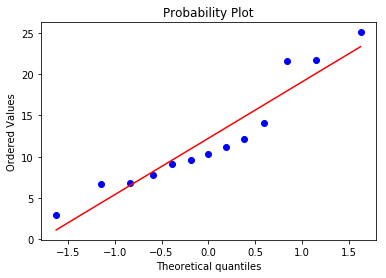

Shapiro-Wilk test results for browse: stat 0.90050727129 p-value 0.135889232159


In [138]:
#subset browse days and check if assumption of normality holds
browse = joined[joined['Browse'] == 'Yes']['TSB (%)'] # subset for browse days
stats.probplot(browse, dist="norm", plot=pylab)
pylab.show()

from scipy.stats import shapiro
stat, p = shapiro(browse)
print 'Shapiro-Wilk test results for browse: stat', stat, 'p-value', p


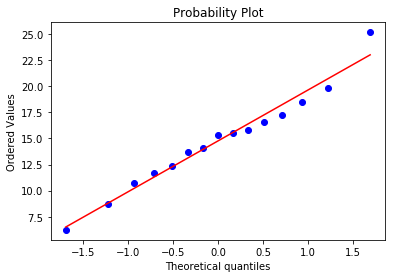

Shapiro-Wilk test results for no browse: stat 0.983117699623 p-value 0.986402273178


In [139]:
#subset non-browse days and check if assumption of normality holds
no_browse = joined[joined['Browse'] == 'No']['TSB (%)'] # subset for browse days
stats.probplot(no_browse, dist="norm", plot=pylab)
pylab.show()

from scipy.stats import shapiro
stat, p = shapiro(no_browse)
print 'Shapiro-Wilk test results for no browse: stat', stat, 'p-value', p

### test for equal variance

In [141]:
import scipy
test_equal_var = scipy.stats.bartlett(browse, no_browse)
test_equal_var

BartlettResult(statistic=1.6673210002978338, pvalue=0.19661774893094897)

### t-test

In [158]:
ttest = stats.ttest_ind(browse, no_browse)
statistic, p = ttest
if p > 0.05:
	print 'No difference in means. Fail to reject H0 since p is', p
else:
	print 'Difference in means. Reject H0 since p is', p
    
print 'mean browse days', round(browse.mean(), 2)
print 'mean of no borwse days', round(no_browse.mean(), 2)

No difference in means. Fail to reject H0 since p is 0.250153784947
mean browse days 12.23
mean of no borwse days 14.76


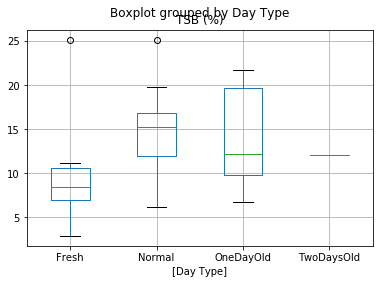

In [145]:
# box plots
#boxplot_browse = joined.boxplot(column = 'TSB (%)', by = ['Day Type'])
#plt.show()

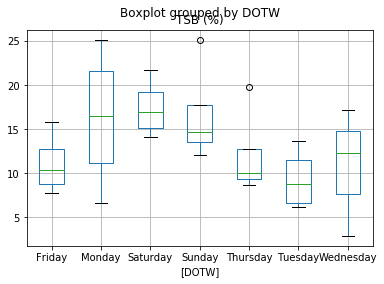

In [146]:
# box plots
#boxplot_browse = joined.boxplot(column = 'TSB (%)', by = ['DOTW'])
#plt.show()

## One way anova with 4 factors

In [148]:
normal = joined[joined['Day Type'] == 'Normal']['TSB (%)']
fresh = joined[joined['Day Type'] == 'Fresh']['TSB (%)']
fresh_no21 = fresh.drop([21])
one_day_old = joined[joined['Day Type'] == 'OneDayOld']['TSB (%)']
two_days_old = joined[joined['Day Type'] == 'TwoDaysOld']['TSB (%)']

# Perform the ANOVA
anova = stats.f_oneway(normal, fresh, one_day_old, two_days_old)
anova

F_onewayResult(statistic=0.83607193142155956, pvalue=0.48732487949430203)

In [149]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

tukey = multi.MultiComparison(joined['TSB (%)'], joined['Day Type'])
Results = tukey.tukeyhsd()
print(Results)


  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2   meandiff  lower    upper  reject
-----------------------------------------------------
  Fresh     Normal    4.3149  -3.3644  11.9943 False 
  Fresh   OneDayOld   3.5963  -5.5823  12.7749 False 
  Fresh   TwoDaysOld  1.6636  -15.508  18.8352 False 
  Normal  OneDayOld  -0.7186   -8.398   6.9607 False 
  Normal  TwoDaysOld -2.6514  -19.0705 13.7678 False 
OneDayOld TwoDaysOld -1.9327  -19.1043 15.2389 False 
-----------------------------------------------------


## Try with Sunday 3rd (Day 21) removed

In [ ]:
joined_no21 = joined.drop([21])

tukey = multi.MultiComparison(joined_no21['TSB (%)'], joined_no21['Day Type'])
Results = tukey.tukeyhsd()
print(Results)

anova = stats.f_oneway(normal, fresh_no21, one_day_old, two_days_old)
anova

In [151]:
swaying_no21_mean = joined_no21.groupby(['Day Type']).mean()
swaying_no21_mean

,TSB (%)
Day Type,
Fresh,7.514444
Normal,14.756914
OneDayOld,14.038272
TwoDaysOld,12.105556


## Include feasability days

In [ ]:
#joined.head()

In [152]:
#create dataframe for feasability data
feasability = pd.DataFrame({'DayNo': [100, 101], 'Date': ['2017-06-07', '2017-06-08'], 'DOTW': ['Wednesday', 'Thursday'], 'Browse': ['Yes', 'No'], 'Day Type': ['Fresh', 'Normal'], 'Section': ['Feasability', 'Feasability'], 'TSB (%)': [5.5, 15.76]})
feasability = feasability.set_index('DayNo')
feasability.head()

,Browse,DOTW,Date,Day Type,Section,TSB (%)
DayNo,,,,,,
100,Yes,Wednesday,2017-06-07,Fresh,Feasability,5.50
101,No,Thursday,2017-06-08,Normal,Feasability,15.76


In [155]:
#add it to the end of the joined data frame
joined_with_feasability = pd.concat([joined, feasability])
joined_with_feasability.tail()

#with feasability but Day21 removed
joined_no21_with_feasability = pd.concat([joined_no21, feasability])
joined_no21_with_feasability.tail()


,Browse,DOTW,Date,Day Type,Section,TSB (%)
DayNo,,,,,,
28,No,Sunday,2017-09-10 00:00:00,Normal,NormalWeek2,15.285185
29,No,Monday,2017-09-11 00:00:00,Normal,NormalWeek2,16.537037
30,No,Tuesday,2017-09-12 00:00:00,Normal,NormalWeek2,10.762963
100,Yes,Wednesday,2017-06-07,Fresh,Feasability,5.500000
101,No,Thursday,2017-06-08,Normal,Feasability,15.760000


In [156]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

tukey_feas = multi.MultiComparison(joined_with_feasability['TSB (%)'], joined_with_feasability['Day Type'])
Results = tukey_feas.tukeyhsd()
print(Results)


  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2   meandiff  lower    upper  reject
-----------------------------------------------------
  Fresh     Normal    5.0836  -1.8934  12.0606 False 
  Fresh   OneDayOld   4.3023  -4.2633  12.8679 False 
  Fresh   TwoDaysOld  2.3696  -14.0896 18.8288 False 
  Normal  OneDayOld  -0.7813  -8.1517   6.589  False 
  Normal  TwoDaysOld -2.7141  -18.5841  13.156 False 
OneDayOld TwoDaysOld -1.9327  -18.5625  14.697 False 
-----------------------------------------------------


In [157]:
tukey_feas_no21 = multi.MultiComparison(joined_no21_with_feasability['TSB (%)'], joined_no21_with_feasability['Day Type'])
Results = tukey_feas_no21.tukeyhsd()
print(Results)


  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2   meandiff  lower    upper  reject
-----------------------------------------------------
  Fresh     Normal    7.6409   1.497   13.7848  True 
  Fresh   OneDayOld   6.8596  -0.5502  14.2694 False 
  Fresh   TwoDaysOld  4.9269  -8.9356  18.7893 False 
  Normal  OneDayOld  -0.7813  -6.9252   5.3625 False 
  Normal  TwoDaysOld -2.7141  -15.9432 10.5151 False 
OneDayOld TwoDaysOld -1.9327  -15.7952 11.9298 False 
-----------------------------------------------------
